Anushna Prakash  
DATA 598 - Deep Learning  
February 4th, 2022  
# <center> Homework 4 </center>  
## 1. Denoising AutoEncoders and Step Decay Learning Rates  

- Use the `MNIST` dataset. Perform the same preprocessing as in this week’s lab.  
- Use the same convolutional autoencoder as in this week’s lab, with a lower latent dimension of 40.  
- As the corruption function $C( \cdot)$, we zero out a randomly chosen $14 \times 14$ patch in the original image. The code for this is provided in the lab again.  
- Train the model for 40 epochs starting with $\gamma_0 = 2.5 \times 10^{−4}$ and take $t_{0} = 10$ (i.e., halve the learning rate every 10 epochs).  

In [1]:
import torch
from torch.nn.functional import relu
from torchvision.datasets import MNIST
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Step 1: Import the data and preprocess.  
Normalize the data over all the pixels, rather than a pixel-wise one.

X_train.shape = torch.Size([6000, 28, 28])
n_train: 6000, n_test: 10000
Image size: torch.Size([28, 28])


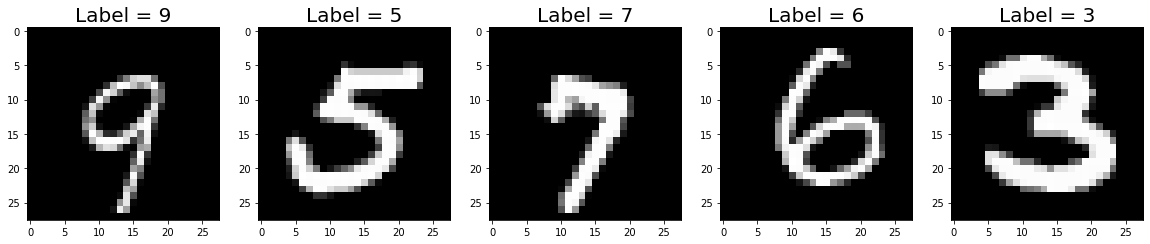

In [2]:
# download dataset (~117M in size)
train_dataset = MNIST('./data', train=True, download=True)
X_train = train_dataset.data # torch tensor of type uint8
y_train = train_dataset.targets # torch tensor of type Long
test_dataset = MNIST('./data', train=False, download=True)
X_test = test_dataset.data
y_test = test_dataset.targets

# choose a subsample of 10% of the data:
idxs_train = torch.from_numpy(
    np.random.choice(X_train.shape[0], replace=False, size=X_train.shape[0]//10)).long()
X_train, y_train = X_train[idxs_train], y_train[idxs_train]
# idxs_test = torch.from_numpy(
#     np.random.choice(X_test.shape[0], replace=False, size=X_test.shape[0]//10))
# X_test, y_test = X_test[idxs_test], y_test[idxs_test]

print(f'X_train.shape = {X_train.shape}')
print(f'n_train: {X_train.shape[0]}, n_test: {X_test.shape[0]}')
print(f'Image size: {X_train.shape[1:]}')

f, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, idx in enumerate(np.random.choice(X_train.shape[0], 5)):
    ax[i].imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)
    ax[i].set_title(f'Label = {y_train[idx]}', fontsize=20)
    
# Normalize the data
X_train = X_train.float()  # convert to float32
# NOTE: we are returning a single mean/std over all the pixels, rather than a pixel-wise one
mean, std = X_train.mean(), X_train.std()  
X_train = (X_train - mean) / (std + 1e-6)  # avoid divide by zero

X_test = X_test.float()
X_test = (X_test - mean) / (std + 1e-6)

### Step 2: Create the AutoEncoder.  
- `EncoderModule`  uses `stride=2`  
- `DecoderModule` uses `stride=2` and `output_padding=1`  
- `AutoEncoder` combines `EncoderModule` and `DecoderModule`  

In [3]:
class EncoderModule(torch.nn.Module):
    """
    Encodes batch images into lower dimensional space
    """
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, 1, 28, 28) -> (B, 4, 12, 12)
        self.conv1 = torch.nn.Conv2d(1, 4, kernel_size=5, stride=2, padding=0) 
        # (B, 4, 12, 12) -> (B, 8, 5, 5)
        self.conv2 = torch.nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=0)
        # Flatten (B, 8, 5, 5) -> (B, 8*5*5): do this in `forward()`
        # (B, 8*5*5) -> (B, lower_dimension); 8*5*5 = 200
        self.linear = torch.nn.Linear(200, lower_dimension)
    
    def forward(self, images):
        out = relu(self.conv1(images))  # conv1 + relu
        out = relu(self.conv2(out))  # conv2 + relu
        out = out.view(out.shape[0], -1)  # flatten
        out = self.linear(out)  # Linear
        return out
    
class DecoderModule(torch.nn.Module):
    """
    Decodes batch images back into original dimensional space
    """
    def __init__(self, lower_dimension):
        super().__init__()
        # (B, lower_dimension) -> (B, linear)
        self.linear_t = torch.nn.Linear(lower_dimension, 200)
        # Unflatten (B, 8*5*5) -> (B, 8, 5, 5); do this in `forward()`
        # Exercise: plug in the output_padding values you determined above
        # (B, 8, 5, 5) -> (B, 4, 12, 12)
        self.conv2_t = torch.nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=0, output_padding=1)
        # (B, 4, 12, 12) -> (B, 1, 28, 28)
        self.conv1_t = torch.nn.ConvTranspose2d(4, 1, kernel_size=5, stride=2, padding=0, output_padding=1)

    def forward(self, x):
        # Apply in reverse order
        out = relu(self.linear_t(x))  # linear_t + relu
        out = out.view(out.shape[0], 8, 5, 5)  # Unflatten
        out = relu(self.conv2_t(out))  # conv2_t + relu
        out = self.conv1_t(out)  # conv1_t (note: no relu at the end)
        return out

class AutoEncoder(torch.nn.Module):
    """
    Takes images in shape (B, 1, 28, 28)
    Encodes down to (B, 8*5*5) for channels=8 of length lower_dimension
    Decodes up from (B, 8*5*5) back to (B, 1, 28, 28)
    """
    def __init__(self, lower_dimension):
        super().__init__()
        self.encoder = EncoderModule(lower_dimension)
        self.decoder = DecoderModule(lower_dimension)
        
    def forward(self, images):
        encoded_images = self.encoder(images)
        decoded_images = self.decoder(encoded_images)
        return decoded_images
        
    def encode_images(self, images):
        """
        Encode images
        """
        return self.encoder(images)
    
    def decode_representations(self, representations):
        """
        Decode lower-dimensional representation
        """
        return self.decoder(representations)

### Step 3: Corrupt images function  

In [4]:
def corrupt_image_batch(images):
    """
    Takes a batch of images and randomly zeros 14x14 square of pixels
    """
    # images: (B, 1, 28, 28)
    patch_size = 14  # zero out a 14x14 patch
    batch_size = images.shape[0]
    height, width = images.shape[-2:]  # height and width of each image
    starting_h = np.random.choice(height - patch_size, size=batch_size, replace=True)
    starting_w = np.random.choice(width - patch_size, size=batch_size, replace=True)

    images_corrupted = images.clone()  # corrupt a copy so we do not lose the originals
    for b in range(batch_size):
        h = starting_h[b]
        w = starting_w[b]
        images_corrupted[b, 0, h:h+patch_size, b:b+patch_size] = 0  # set to 0
    return images_corrupted

### Step 4: Edit functions  
$$\min_{w,v} \mathbb{E}_{x} = \| x - g_{v} \circ h_{w}(C(x)) \| ^2$$

In [5]:
def loss_function(true_images, reconstructed_images):
    """
    Takes the true images and the reconstructed corrupted images
    Returns the squared loss
    """
    residual = (true_images - reconstructed_images).view(-1)  # flatten into a vector
    # return the average over examples
    return 0.5 * torch.norm(residual) ** 2 / (true_images.shape[0])

def compute_objective(model, true_images, corrupted_images):
    """
    Takes original images and corrupted images.
    Returns the objective.
    """
    reconstructed_images = model(corrupted_images)
    return loss_function(true_images, reconstructed_images)

@torch.no_grad()
def compute_logs(
    model, train_true_images, train_corrupted_images, # training variables
    test_true_images, test_corrupted_images, # test variables
    verbose=False):
    """
    Compute and return train and test loss
    """
    train_loss = compute_objective(model, train_true_images, train_corrupted_images)
    test_loss = compute_objective(model, test_true_images, test_corrupted_images)
    
    if verbose:
        print('Train Loss = {:.3f}, Test Loss = {:.3f}, '.format(
                train_loss.item(), test_loss.item(),
    ))
    
    return (train_loss, test_loss)

def minibatch_sgd_one_pass(model, true_images, corrupted_images, learning_rate, batch_size, verbose=False):
    num_examples = corrupted_images.shape[0]
    average_loss = 0.0
    num_updates = int(round(num_examples / batch_size))
    for i in range(num_updates):
        idxs = np.random.choice(num_examples, size=(batch_size,))
        # compute the objective. 
        objective = compute_objective(model, true_images[idxs], corrupted_images[idxs]) 
        average_loss = 0.99 * average_loss + 0.01 * objective.item()
        if verbose and (i+1) % 100 == 0:
            print("{:.3f}".format(average_loss))
         
        # Perform the SGD update
        gradients = torch.autograd.grad(outputs=objective, inputs=model.parameters())
        with torch.no_grad():
            for w, g in zip(model.parameters(), gradients):
                w -= learning_rate * g
    
    return model

### Step 5:  Train the model  
- 40 epochs starting with $\gamma_0 = 2.5 \times 10^{−4}$ and take $t_{0} = 10$ (i.e., halve the learning rate every 10 epochs).   

In [6]:
# Add channel = 1 dimension to data
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)
# Create corrupted data
C_X_train = corrupt_image_batch(X_train)
C_X_test = corrupt_image_batch(X_test)

In [ ]:
# Train model
ae_model = AutoEncoder(lower_dimension=40)
EPOCHS = 40
T_0 = 10
gamma = 2.5 * 10e-5 * 2 # This will be halved in the first iteration

logs = []
logs.append(compute_logs(ae_model, X_train, C_X_train, X_test, C_X_test, verbose=True))

for i in range(EPOCHS):
    # Update learning rate parameter every T_0 epochs
    if i % T_0 == 0:
        gamma = gamma / 2
        print(f'gamma = {gamma}')
    
    ae_model = minibatch_sgd_one_pass(ae_model, X_train, C_X_train, gamma, batch_size=1)
    logs.append(compute_logs(ae_model, X_train, C_X_train, X_test, C_X_test, verbose=True))

Train Loss = 401.571, Test Loss = 411.135, 
gamma = 0.00025
Train Loss = 101.112, Test Loss = 100.862, 
Train Loss = 67.436, Test Loss = 67.231, 
Train Loss = 57.851, Test Loss = 57.434, 
Train Loss = 55.334, Test Loss = 55.137, 
Train Loss = 49.588, Test Loss = 49.338, 
Train Loss = 48.332, Test Loss = 48.109, 
Train Loss = 51.540, Test Loss = 51.625, 
Train Loss = 47.901, Test Loss = 47.673, 
Train Loss = 46.287, Test Loss = 46.219, 
Train Loss = 44.288, Test Loss = 44.219, 
gamma = 0.000125
Train Loss = 41.163, Test Loss = 41.131, 
Train Loss = 41.059, Test Loss = 41.101, 
Train Loss = 41.011, Test Loss = 41.092, 
Train Loss = 40.540, Test Loss = 40.557, 
Train Loss = 41.041, Test Loss = 41.072, 
Train Loss = 40.017, Test Loss = 39.995, 
Train Loss = 40.833, Test Loss = 40.883, 
Train Loss = 39.367, Test Loss = 39.466, 
Train Loss = 39.621, Test Loss = 39.766, 
Train Loss = 39.375, Test Loss = 39.476, 
gamma = 6.25e-05
Train Loss = 38.323, Test Loss = 38.447, 
Train Loss = 38.323, T

In [ ]:
fig = plt.figure(figsize = (16, 8))

plt.plot(np.asarray(logs)[:, 0], label='Train')
plt.plot(np.asarray(logs)[:, 1], label='Test')
plt.legend(fontsize=12)
plt.title('Loss over epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Iterations', fontsize=12)